In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rbo

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

sys.path.append("/home/dhoof/master-thesis-automatic-selection/benchmark/metrics-analysis")
sys.path.append("/home/dhoof/pytorch-pretrained-cnns")
from metrics.loader import CheckpointLoader, MetricsLoader
from metrics.loader.calculate_metrics import ArchitectureSizeMetrics, QualityMetrics, LatentSpaceMetrics, InformationalMetrics
from metrics.analysis.random_forest_pipeline import RandomForestPipeline
from metrics.analysis.random_forest_pca_pipeline import RandomForestPCAPipeline

/home/dhoof/.conda/envs/pytorch111/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Static Parameters
pretrained_checkpoints_path="output/"
pretrained_checkpoint=(0, "pretrained")
pretrained_datasets=[("cifar10", 100), ("cifar100", 100), ("grocerystore", 100), ("svhn", 100), ("tinyimagenet", 100)]

finetune_checkpoints_path="output_sweep_complete/"
finetune_checkpoints=[
    (0,"cifar10_model"),
    (1,"cifar100_model"),
    (2,"grocerystore_model"),
    (3,"svhn_model"),
    (4,"tinyimagenet_model")
]
finetune_datasets=[("cifar10", 5), ("cifar100", 5), ("grocerystore", 15), ("svhn", 5), ("tinyimagenet", 5)]
from_scratch_checkpoint=(5, "from_scratch")

models=["lowres_resnet9","lowres_resnet50","lowres_densenet121","lowres_vgg16_bn"]
all_datasets_path="../SSD/datasets"

use_cached_df_if_available=True
# cache_csv_path="full_metrics_kmeans_df.csv"
replace_cache = False

target='difference'

# hyperparameters

def get_metrics():    
    return [
        QualityMetrics(),
        ArchitectureSizeMetrics(),
        LatentSpaceMetrics(cluster_model_name='kmeans', prefix='kmeans'),
        LatentSpaceMetrics(cluster_model_name='dbscan', prefix='dbscan')
    ]
    
    # if mode == "static":
    #     return [
    #         QualityMetrics(),
    #         ArchitectureSizeMetrics()
    #     ]
    # if mode == "static_weighted":
    #     return [
    #         QualityMetrics(),
    #         ArchitectureSizeMetrics()
    #     ]
    # if mode == "dynamic":
    #     return [
    #         QualityMetrics(),
    #         ArchitectureSizeMetrics(),
    #         LatentSpaceMetrics(cluster_model_name=cluster_algorithm)
    #     ]
    # if mode == "dynamic_weighted":
    #     return [
    #         QualityMetrics(),
    #         ArchitectureSizeMetrics(),
    #         LatentSpaceMetrics(cluster_model_name=cluster_algorithm)
    #     ]
    # if mode == "all":
    #     return [
    #         QualityMetrics(),
    #         ArchitectureSizeMetrics(),
    #         LatentSpaceMetrics(cluster_model_name=cluster_algorithm)
    #     ]
    
def get_features(cluster_algorithm, metrics_range, df):    
    # if feature_selection == 'all_parameters':
    #     return df.loc[:, ~df.columns.isin(['checkpoint', 'finetune_dataset','model','pretrained_dataset',"dataset",'difference'])].columns
    # if feature_selection == 'selected_parameters':
    if metrics_range == 'static':
        return list(df.loc[:, ~df.columns.isin([
            'checkpoint', 
            'finetune_dataset',
            'model',
            'pretrained_dataset',
            "dataset",
            'difference',
            'weighted_sparsity',
            'weighted_variance_entropy',
            'weighted_variance_entropy_clean'
        ]+ [ f'{c_a}_latent_space_silhouette_score' for c_a in clustering_algorithms])].columns) 

    if metrics_range == 'static_weighted':
        return list(df.loc[:, ~df.columns.isin([
            'checkpoint', 
            'finetune_dataset',
            'model',
            'pretrained_dataset',
            "dataset",
            'difference',
            'sparsity',
            'variance_entropy',
            'variance_entropy_clean'
        ]+ [ f'{c_a}_latent_space_silhouette_score' for c_a in clustering_algorithms])].columns) 
    
    if metrics_range == 'static_both':
        return list(df.loc[:, ~df.columns.isin([
            'checkpoint', 
            'finetune_dataset',
            'model',
            'pretrained_dataset',
            "dataset",
            'difference',            
        ]+ [ f'{c_a}_latent_space_silhouette_score' for c_a in clustering_algorithms])].columns)         

    if metrics_range == 'dynamic':
        return list(df.loc[:, ~df.columns.isin([
            'checkpoint', 
            'finetune_dataset',
            'model',
            'pretrained_dataset',
            "dataset",
            'difference',       
            'weighted_sparsity',
            'weighted_variance_entropy',
            'weighted_variance_entropy_clean',
        ]+ [ f'{c_a}_latent_space_silhouette_score' for c_a in clustering_algorithms])].columns) + [ f'{c_a}_latent_space_silhouette_score' for c_a in clustering_algorithms if c_a == cluster_algorithm]
    

    if metrics_range == 'dynamic_weighted':
        return list(df.loc[:, ~df.columns.isin([
            'checkpoint', 
            'finetune_dataset',
            'model',
            'pretrained_dataset',
            "dataset",
            'difference',       
            'sparsity',
            'variance_entropy',
            'variance_entropy_clean',
        ]+ [ f'{c_a}_latent_space_silhouette_score' for c_a in clustering_algorithms])].columns) + [ f'{c_a}_latent_space_silhouette_score' for c_a in clustering_algorithms if c_a == cluster_algorithm]
    
    if metrics_range == 'all':
        return list(df.loc[:, ~df.columns.isin([
            'checkpoint', 
            'finetune_dataset',
            'model',
            'pretrained_dataset',
            "dataset",
            'difference'
        ]+ [ f'{c_a}_latent_space_silhouette_score' for c_a in clustering_algorithms])].columns) + [ f'{c_a}_latent_space_silhouette_score' for c_a in clustering_algorithms if c_a == cluster_algorithm] 
    
    if metrics_range == "latent":
        return [ f'{cluster_algorithm}_latent_space_silhouette_score']
    
    if metrics_range == "None":
        return list(df.loc[:, ~df.columns.isin([
            'checkpoint', 
            'finetune_dataset',
            'model',
            'pretrained_dataset',
            "dataset",
            'difference',
            'weighted_sparsity',
            'weighted_variance_entropy',
            'weighted_variance_entropy_clean',
            'sparsity',
            'variance_entropy',
            'variance_entropy_clean'
        ]+ [ f'{c_a}_latent_space_silhouette_score' for c_a in clustering_algorithms])].columns) 
    

metrics_ranges=[
    'static',
    'static_weighted',
    'static_both',
    'dynamic',
    'dynamic_weighted',
    'latent',
    'all',
    'None'
]

clustering_algorithms=[
    'kmeans',
    'dbscan'
]

In [3]:
hyperparameters = []

metrics_loader = MetricsLoader(
                        pretrained_cp_loader=CheckpointLoader(pretrained_checkpoints_path, all_datasets_path),
                        pretrained_checkpoint=pretrained_checkpoint,
                        finetune_cp_loader=CheckpointLoader(finetune_checkpoints_path, all_datasets_path),
                        finetune_checkpoints=finetune_checkpoints,
                        from_scrape_cp_loader=CheckpointLoader(finetune_checkpoints_path, all_datasets_path),
                        from_scratch_checkpoint=from_scratch_checkpoint,
                        metrics=get_metrics(),
                        finetune_datasets=finetune_datasets,
                        pretrained_datasets=pretrained_datasets,
                        models=models,
                        use_finetune_dataset=False
                    )

if use_cached_df_if_available and os.path.exists(f"cache/metrics.csv") and not replace_cache:
    metrics_df=pd.read_csv(f"cache/metrics.csv",index_col=[0])
else:
    metrics_df=metrics_loader.load_all_metrics()
    
if not os.path.exists(f"cache/metrics.csv") or replace_cache:
    metrics_df.to_csv(f"cache/metrics.csv")

for metrics_range in metrics_ranges:
    for cluster_algorithm in clustering_algorithms:        
        if metrics_range == "static":
            if "static" in [hyperparameter[0] for hyperparameter in hyperparameters]:
                continue;
            name = f"{metrics_range}" 
        elif metrics_range == "static_weighted":
            if  "static_weighted" in [hyperparameter[0] for hyperparameter in hyperparameters]:
                continue;
            name = f"{metrics_range}"     
        elif metrics_range == "static_both":
            if  "static_both" in [hyperparameter[0] for hyperparameter in hyperparameters]:
                continue;
            name = f"{metrics_range}"
        else:
            name = f"{metrics_range}_{cluster_algorithm}"

        ohe_df=pd.concat([metrics_df,pd.get_dummies(metrics_df['model'], prefix='model'),pd.get_dummies(metrics_df['pretrained_dataset'], prefix='pretrained_dataset')],axis=1).fillna(0)

        features = get_features(cluster_algorithm,metrics_range, ohe_df)
        # print(name)
        # print(features)
        

        hyperparameters.append((name, ohe_df, features))
            

In [4]:
def calculate_predict_diff(pipeline, df, X, y):
    info_df=df[df['difference'].isin(y)]
    
    assignment_list=list(zip(list(pipeline.predict(X)),list(y)))
    
    predict_df = pd.DataFrame.from_records(assignment_list, columns=['difference_predict','difference'])
    df = info_df.merge(predict_df, on='difference', how='inner')
    return df

In [5]:
import multiprocessing as mp
import random
import time



class RandomPipeline:
    def __init__(self):        
        random.seed(str(RandomForestPipeline([]))+str(time.time()))    

    class _random_predict:
        def __init__(self, len_):
            self.len_ = len_
            
        def __call__(self, x):
            return [random.uniform(-1,1) * 100 for x in range(self.len_)]
        
        
    def predict(self, X):           
        return self._random_predict(len(X))(0)

In [6]:
random_pipeline = RandomPipeline()

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_dataset(X_batches, finetune_dataset_name, split):
    if split == "train":
        return {"X":X_batches[finetune_dataset_name][1], "y":X_batches[finetune_dataset_name][4]}
    if split == "test":
        return {"X":X_batches[finetune_dataset_name][2], "y":X_batches[finetune_dataset_name][5]}
    if split == "all":
        return {"X":X_batches[finetune_dataset_name][0], "y":X_batches[finetune_dataset_name][3]}
    return {}

def get_ranking_error(all_dfs): 
    def get_error(datasets, c=1):
        if type(datasets) == str:
            datasets=[datasets]
        errors=[]
        for dataset in datasets:
            predicted_real=np.array(all_dfs[dataset].sort_values(by="difference_predict", ascending=False)['difference'])
            real=np.array(all_dfs[dataset].sort_values(by="difference", ascending=False)['difference'])
            # print(predicted_real-real)
            errors.append((predicted_real-real)[:c])
        return np.array(errors).mean()
    return get_error

In [8]:
class Evaluation:
    
    def __init__(self, X_batches,df,regr_pipeline, split, finetune_datasets):
        self.split = split
        self.X_batches = X_batches
        self.regr_pipeline = regr_pipeline
        self.df = df
        
        self.all_predict_dfs = {}
        self.all_random_dfs = {}    
        
        self.finetune_datasets = finetune_datasets
        self.random_pipeline = RandomPipeline()
        
        self.__init_dfs()
        
    def __init_dfs(self):
        for dataset in self.finetune_datasets:
            self.all_predict_dfs[dataset]=calculate_predict_diff(self.regr_pipeline, self.df, **get_dataset(self.X_batches,dataset,self.split))
            self.all_random_dfs[dataset]=calculate_predict_diff(self.random_pipeline, self.df, **get_dataset(self.X_batches,dataset,self.split))
    
    
    def ranking_error(self, c=1):
        return get_ranking_error(self.all_predict_dfs)(self.finetune_datasets,c=c)
    
    def get_metrics(self):
#         y_true = y_train
#         y_pred = self.regr_pipeline.predict(X_train)

#         print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
#         print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
#         print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
#         print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_true, y_pred))
#         print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
#         print('Max Error:', metrics.max_error(y_true, y_pred))
#         print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_true, y_pred))
#         print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
#         print('R^2:', metrics.r2_score(y_true, y_pred))
#         print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_true, y_pred))
#         print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_true, y_pred))
#         metrics={}
#         metrics['r2_value']=self.regr_pipeline
        pass

    def plot_importances(self, figsize=(10,10),c=None):
        
        X_all,y_all = [],[]
        for dataset in self.finetune_datasets:
            X_temp = get_dataset(self.X_batches,dataset,self.split)['X']
            y_temp = get_dataset(self.X_batches,dataset,self.split)['y']
            for values in X_temp:        
                X_all.append(values)
            for values in y_temp:
                y_all.append(values)            
            
        return self.regr_pipeline.plot_importances(np.array(X_all),np.array(y_all),figsize=figsize,c=c)
        
    
    def plot(self, figsize=(10,10)):
        cols = 2
        rows = int(np.ceil(len(self.finetune_datasets)/2))

        finetune_datasets_reshape=[]

        temp=[]
        for idx, dataset in enumerate(self.finetune_datasets):
            temp.append(dataset)
            if (idx+1) % (cols) == 0:
                finetune_datasets_reshape.append(temp)
                temp=[]


        # print(finetune_datasets_reshape)


        fig, ax = plt.subplots(cols,rows,figsize=figsize)

        for col in range(cols):
            for row in range(rows):
                # print()
                self.all_predict_dfs[finetune_datasets_reshape[row][col]].sort_values(by="difference_predict", ascending=False)[['finetune_dataset','pretrained_dataset','model','difference_predict']].set_index(['finetune_dataset','pretrained_dataset','model']).plot.bar(ax=ax[row,col], rot=90)
                self.all_predict_dfs[finetune_datasets_reshape[row][col]].sort_values(by="difference_predict", ascending=False)[['finetune_dataset','pretrained_dataset','model','difference']].set_index(['finetune_dataset','pretrained_dataset','model']).plot(ax=ax[row,col], rot=90,color="red")
                # ax[row,col].set_xlabel(all_predict_dfs[finetune_datasets_reshape[row][col]])
                ax[row,col].set_title(f"Finetuned on {finetune_datasets_reshape[row][col]}")
                # ax[row,col].set_xlabel(ax[row,col].get_xlabel(),rotation=45)
        fig.tight_layout()
        return fig

In [9]:
[hyperparameter[0] for hyperparameter in hyperparameters]

['static',
 'static_weighted',
 'static_both',
 'dynamic_kmeans',
 'dynamic_dbscan',
 'dynamic_weighted_kmeans',
 'dynamic_weighted_dbscan',
 'latent_kmeans',
 'latent_dbscan',
 'all_kmeans',
 'all_dbscan',
 'None_kmeans',
 'None_dbscan']

In [716]:
number_of_runs=100

exp='da_3'

experiments={
    'rf_1':0,
    'rf_2':1,
    'rf_3':2,
    'rf_4':3,
    'rf_5':4,
    'da_1':2,
    'da_2':7,
    'da_3':9,
    'None':11
            }

print(hyperparameters[experiments[exp]][0])
df=hyperparameters[experiments[exp]][1]
features = hyperparameters[experiments[exp]][2]
print(hyperparameters[experiments[exp]][2])

target = "difference"

all_kmeans
['sparsity', 'variance_entropy', 'variance_entropy_clean', 'weighted_sparsity', 'weighted_variance_entropy', 'weighted_variance_entropy_clean', 'architecture_size_Conv2d', 'architecture_size_BatchNorm2d', 'architecture_size_ReLU', 'architecture_size_MaxPool2d', 'architecture_size_Flatten', 'architecture_size_Linear', 'architecture_size', 'architecture_size_AdaptiveAvgPool2d', 'architecture_size_AvgPool2d', 'architecture_size_Dropout', 'model_lowres_densenet121', 'model_lowres_resnet50', 'model_lowres_resnet9', 'model_lowres_vgg16_bn', 'pretrained_dataset_cifar10(100)', 'pretrained_dataset_cifar100(100)', 'pretrained_dataset_grocerystore(100)', 'pretrained_dataset_svhn(100)', 'pretrained_dataset_tinyimagenet(100)', 'kmeans_latent_space_silhouette_score']


In [717]:
X_batches = {}

for dataset in finetune_datasets:    
    df_fine = df[df['finetune_dataset'] == f"{dataset[0]}({dataset[1]})"]
    y_fine = df_fine[target].to_numpy()
    X_fine = df_fine[features].to_numpy()#.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X_fine, y_fine, test_size=0.2, random_state=42)
    
    X_batches[dataset] = (X_fine, X_train, X_test, y_fine, y_train, y_test)




# X_train_full, y_train_full = [],[]
# for X_fine, X_train, X_test, y_fine, y_train, y_test in X_batches.values():
#     for values in X_train:        
#         X_train_full.append(values)
#     for values in y_train:
#         y_train_full.append(values)      

In [718]:
%autoreload 2
from sklearn import metrics
split="test"
scores=[]

number_of_runs=1

X_train_full, y_train_full, X_test_full, y_test_full = [],[],[],[]
for X_fine, X_train, X_test, y_fine, y_train, y_test in X_batches.values():
    for values in X_train:        
        X_train_full.append(values)
    for values in y_train:
        y_train_full.append(values)   
    for values in X_test:        
        X_test_full.append(values)
    for values in y_test:
        y_test_full.append(values) 
        
X_train_full=np.array(X_train_full)
y_train_full=np.array(y_train_full)
X_test_full=np.array(X_test_full)
y_test_full=np.array(y_test_full)

regr_pipeline=None

for run in range(number_of_runs):
    regr_pipeline = RandomForestPipeline(features)
    regr_pipeline.fit(np.array(X_train_full),np.array(y_train_full))
    eval_=Evaluation(X_batches,df,regr_pipeline, split, finetune_datasets)

    if split == 'test':        
        print(regr_pipeline.score(X_test_full,y_test_full))
        print(metrics.mean_squared_error(regr_pipeline.predict(X_test_full),y_test_full, squared=False))
        print(eval_.ranking_error())
        scores.append((regr_pipeline.score(X_test_full,y_test_full),metrics.mean_squared_error(regr_pipeline.predict(X_test_full),y_test_full, squared=False),eval_.ranking_error()))
    if split == 'train':        
        print(regr_pipeline.score(X_train_full,y_train_full))
        print(metrics.mean_squared_error(regr_pipeline.predict(X_train_full),y_train_full, squared=False))
        print(eval_.ranking_error())
        scores.append((regr_pipeline.score(X_train_full,y_train_full),metrics.mean_squared_error(regr_pipeline.predict(X_train_full),y_train_full, squared=False),eval_.ranking_error()))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END rf__bootstrap=True, rf__max_depth=80, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=8; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=80, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=8; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=80, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=8; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=22; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=10, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=15; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=22; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=22; 

In [719]:
np.array(scores).mean(axis=0)

array([ 0.1544433 , 17.27280125, -1.41022501])

In [720]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
linear_regr_pipeline = Pipeline([('scaler',StandardScaler()),('lr', LinearRegression())])

In [721]:
linear_regr_pipeline.fit(X_train_full,y_train_full)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])

In [722]:
# eval_linear = Evaluation(X_batches,df,linear_regr_pipeline, split, finetune_datasets)

# if split == 'test':
#     print(linear_regr_pipeline.score(X_test_full,y_test_full))
#     print(metrics.mean_squared_error(linear_regr_pipeline.predict(X_test_full),y_test_full, squared=False))
#     print(eval_linear.ranking_error())
# if split == 'train':
#     print(regr_pipeline.score(X_train_full,y_train_full))
#     print(metrics.mean_squared_error(regr_pipeline.predict(X_train_full),y_train_full, squared=False))
#     print(eval_linear.ranking_error())

In [723]:
# number_of_runs_random=10_000

# random_scores = []

# for run in range(number_of_runs_random):
#     random_pipeline = RandomPipeline()
#     eval_random = Evaluation(X_batches,df,random_pipeline, split, finetune_datasets)

#     if split == 'test':
#         # print(random_pipeline.score(X_test_full,y_test_full))
#         # print(metrics.mean_squared_error(random_pipeline.predict(X_test_full),y_test_full, squared=False))
#         # print(eval_random.ranking_error())
#         random_scores.append((
#             metrics.r2_score(y_test_full,random_pipeline.predict(X_test_full)),
#             metrics.mean_squared_error(random_pipeline.predict(X_test_full),y_test_full, squared=False),
#             eval_random.ranking_error())
#         )
        
#     if split == 'train':
#         # print(regr_pipeline.score(X_train_full,y_train_full))
#         # print(metrics.r2_score(random_pipeline.predict(X_train_full),y_train_full))
#         # print(metrics.mean_squared_error(random_pipeline.predict(X_train_full),y_train_full, squared=False))
#         # print(eval_random.ranking_error())
#         random_scores.append((            
#             metrics.r2_score(y_train_full,random_pipeline.predict(X_train_full)),
#             metrics.mean_squared_error(random_pipeline.predict(X_train_full),y_train_full, squared=False),
#             eval_random.ranking_error())
#         )

In [724]:
# np.array(random_scores).mean(axis=0)

In [725]:
# for dataset in finetune_datasets:
#     eval_.all_predict_dfs[dataset][['pretrained_dataset','model','difference','difference_predict']].set_index(['pretrained_dataset','model']).sort_values(by=['pretrained_dataset','model']).to_csv(f"cache/diff_{dataset[0]}_{dataset[1]}_{split}.csv")

In [726]:
import math

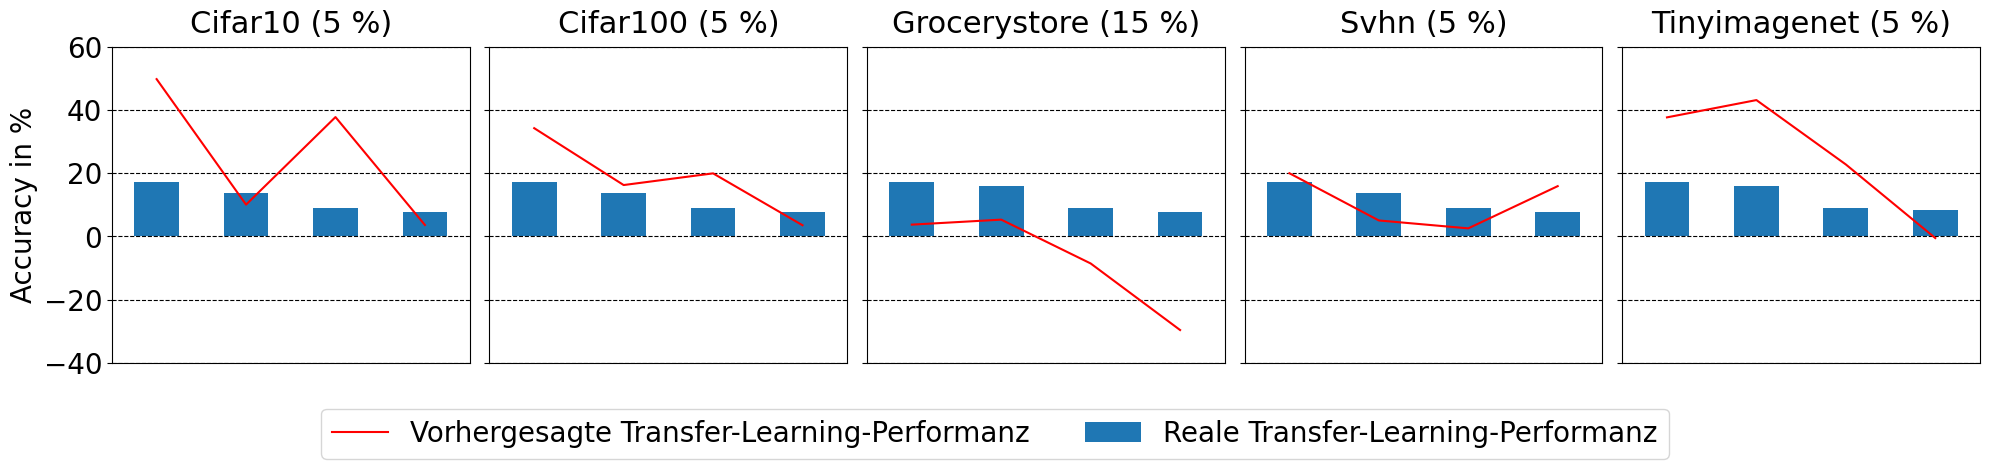

In [727]:
cols = len(finetune_datasets)

# print(finetune_datasets_reshape)


fig, ax = plt.subplots(1,cols,figsize=(20,4))

min_ylims = []
max_ylims = []

for col in range(cols):   
        # print()
    eval_.all_predict_dfs[finetune_datasets[col]].sort_values(by="difference_predict", ascending=False)[['finetune_dataset','pretrained_dataset','model','difference_predict']].set_index(['finetune_dataset','pretrained_dataset','model']).plot.bar(ax=ax[col], rot=90,legend=False)
    eval_.all_predict_dfs[finetune_datasets[col]].sort_values(by="difference_predict", ascending=False)[['finetune_dataset','pretrained_dataset','model','difference']].set_index(['finetune_dataset','pretrained_dataset','model']).plot(ax=ax[col], rot=90,color="red",legend=False)
    # ax[row,col].set_xlabel(all_predict_dfs[finetune_datasets_reshape[row][col]])
    ax[col].set_title(f"{finetune_datasets[col][0].capitalize()} ({finetune_datasets[col][1]} %)",fontsize=22,pad=10)
    ax[col].get_xaxis().set_visible(False)
    min_ylims.append(ax[col].get_ylim()[0])
    max_ylims.append(ax[col].get_ylim()[1])
        # ax[row,col].set_xlabel(ax[row,col].get_xlabel(),rotation=45)
        

        
for iax, ax_ in enumerate(ax):
    if iax != 0:
        ax_.set_yticklabels([])
    else:
        ax_.set_ylabel('Accuracy in %',fontsize=20)
    for label in ax_.get_yticklabels():
        # label.set_fontname('Arial')
        label.set_fontsize(20)
    ax_.set_ylim(math.floor(min(min_ylims)/10)*10,math.ceil(max(max_ylims)/10)*10)    
    # print( ax_.get_ylim())
    ax_.grid(True,color="black",linestyle='--')

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
          ncol=2, fancybox=True,labels=['Vorhergesagte Transfer-Learning-Performanz','Reale Transfer-Learning-Performanz'],fontsize=20)

fig.tight_layout()
fig.savefig(f"images/analysis_new/reg_exp_{exp}_{split}.png", bbox_inches='tight')
fig.show()

In [728]:
min(min_ylims)

-31.951915387368857

In [566]:
type(math.ceil(max(max_ylims)/10)*10)

int

In [498]:
min_ylims

[0.0, 0.0, -31.951915387368857, 0.0, -2.693126618862152]

In [499]:
max_ylims

[52.25735893249511,
 35.96425437927246,
 19.650860036601483,
 20.99355125427246,
 45.320673644542694]

In [500]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [501]:
# df.columns

In [502]:
shotcut_labels={
    'Finetuning-Datensatz',
    'Pretraining-Datensatz',
    'Architektur',
    'Checkpoint',
    'Sparsity',
    'Entropie-Varianz',
    'Gereinigte Entropie-Varianz',
    'Gewichtete Sparsity',
    'Gewichtete Entropie-Varianz',
    'Gewichtete gereinigte Entropie-Varianz',
    'Architekturgröße (Conv2d)',
    'Architekturgröße (BatchNorm2d)',
    'Architekturgröße (ReLU)',
    'Architekturgröße (MaxPool)',
    'Architekturgröße (Flatten)',
    'Architekturgröße (Linear)',
    'Architekturgröße (gesamt)',
    'Latent-Space-Silhouettenkoeffizienten',
    'Transfer-Learning-Performanz',
    'Architekturgröße (ApdaptiveAvgPool2d)',
    'Architekturgröße (AvgPool2d)',
    'Architekturgröße (Dropout)',
    'Architektur (DenseNet-121)',
    'Architektur (ResNet-50)',
    'Architektur (ResNet-9)',
    'Architektur (VGG-16-bn)',
    'Pretrainig-Datensatz (CIFAR-10)',
    'Pretrainig-Datensatz (CIFAR-100)',
    'Pretrainig-Datensatz (GroceryStore)',
    'Pretrainig-Datensatz (SVHN)',
    'Pretrainig-Datensatz (TinyImageNet)',
}

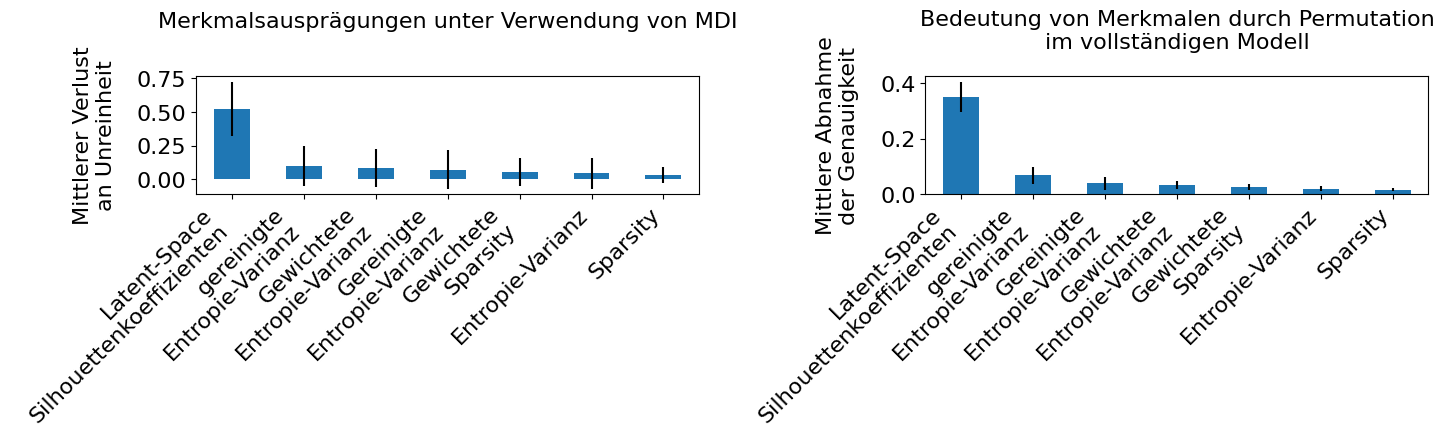

In [504]:
eval_imp = Evaluation(X_batches,df,regr_pipeline, 'train', finetune_datasets)

fig=eval_imp.plot_importances(figsize=(15,5),c=7)
ax=fig.axes
for iax, ax_ in enumerate(ax):
    y_labels = ax_.get_ylabel().split(" ")
    y_label=y_labels[0]+" "+y_labels[1]+"\n"+y_labels[2]+" "+y_labels[3]
    ax_.set_ylabel(y_label,fontsize=16,labelpad=15)    
    
    if iax != 0:    
        ax_.set_title("Bedeutung von Merkmalen durch Permutation\nim vollständigen Modell",fontsize=16, pad=20)
    else:
        ax_.set_title(ax_.get_title(),fontsize=16, pad=35)
    
    x_labels = [x_tick.get_text().split(" ")[len(x_tick.get_text().split(" "))-2]+"\n"+x_tick.get_text().split(" ")[len(x_tick.get_text().split(" "))-1] if len(x_tick.get_text().split(" "))>=2 else x_tick.get_text() for x_tick in ax_.get_xticklabels() ]   
    # x_labels = [x_tick.get_text().split(" ")[0]+x_tick.get_text().split(" ")[1]+"\n"+x_tick.get_text().split(" ")[2] if len(x_tick.get_text().split(" "))==3 else x_tick.get_text() for x_tick in ax_.get_xticklabels() ] 
    
    ax_.set_xticklabels(x_labels)
    
    for label in (ax_.get_yticklabels()+ax_.get_xticklabels()):
        # label.set_fontname('Arial')
        label.set_fontsize(16)
        
    # for tick in ax_.xaxis.get_major_ticks()[1::2]:
    #     tick.set_pad(60)
        
    # ax_.set_xticks(ax_.get_xticks(), ax_.get_xticklabels(),rotation=0, ha="center")
fig.tight_layout(pad=3.0)
fig.savefig(f"images/analysis_new/feature_importances_reg_exp_{exp}.png")
fig.show()